# Pacific Northwest Geodetic Array GPS Time Series Analysis

### [http://www.geodesy.cwu.edu](http://www.geodesy.cwu.edu)

In [1]:
from IPython.display import Image 
Image(url='http://www.geodesy.cwu.edu/graphics/banner3.1-resized.jpg')

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import gpstools as gps

In [3]:
plt.style.use('seaborn-white')
%matplotlib notebook
%qtconsole

# Load time series

In [4]:
# We'll use station TPW2
station = 'TPW2'
refframe= 'ITRF2008'
# Reference frame is ITRF2008
# Download data
gps.panga.download_data(station, overwrite=False)

TPW2 already dowloaded... skipping
TPW2 already dowloaded... skipping
TPW2 already dowloaded... skipping


In [5]:
# Load the timeseries as pandas dataframe
df = gps.panga.load_panga(station)

In [6]:
df.head()

,decyear,east,err_e,north,err_n,up,err_u
date,,,,,,,
2000-03-30,2000.24367,-43.44176,6.44261,-43.90224,4.16261,1.79662,15.36770
2000-03-31,2000.24641,-45.79030,3.04885,-37.59347,2.06967,-6.72731,6.70038
2000-04-01,2000.24914,-44.12896,3.01839,-38.36243,2.07357,-6.90083,6.51643
2000-04-02,2000.25188,-44.61936,3.02401,-37.61145,2.06194,-12.07732,6.56471
2000-04-03,2000.25462,-43.89246,3.06906,-38.40910,2.07690,-3.70381,6.68323


# Plot the time series

<IPython.core.display.Javascript object>


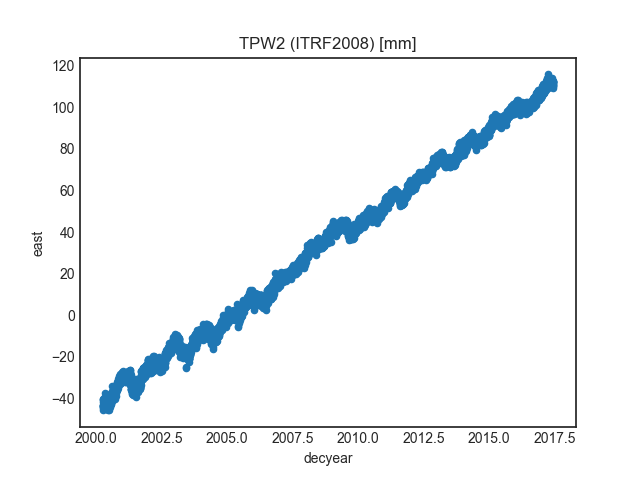

In [24]:
titlestr = '{} ({}) [mm]'.format(station, refframe)
ax = df.plot.scatter('decyear', 'east', title=titlestr)

<IPython.core.display.Javascript object>


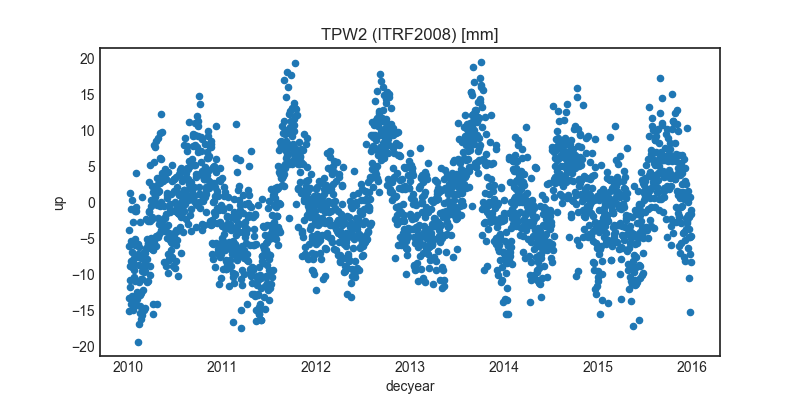

In [25]:
# Particular date range
df['2010/01/01':'2015/12/31'].plot.scatter('decyear', 'up', title=titlestr, figsize=(8,4))

<IPython.core.display.Javascript object>


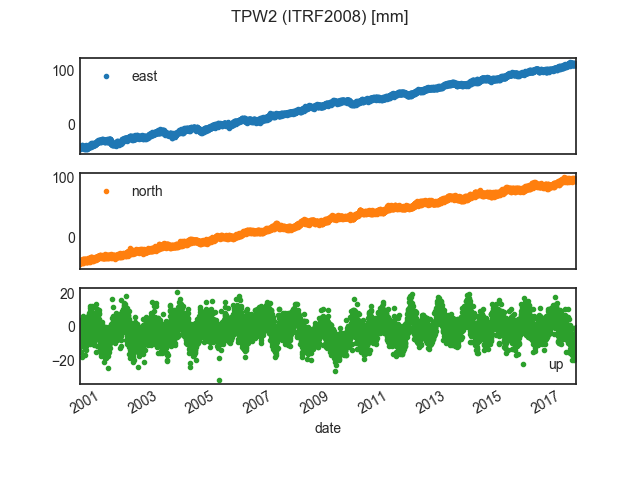

In [26]:
axes = df.plot(y=['east','north','up'], style='.' ,sharex=True, subplots=True, title=titlestr)

# Query Panga archive, station info etc

### [Repository](http://www.geodesy.cwu.edu/pangagsac/gsacapi/repository/view)

http://www.unavco.org/gsacws/gsacapi/site/search?site.code.searchtype=exact&site.code=TPW2&output=site.html

many output types, including json and csv
http://www.unavco.org/gsacws/gsacapi/site/search?site.code.searchtype=exact&site.code=TPW2&output=site.json

PANGA instead of full UNAVCO database
http://www.geodesy.cwu.edu/pangagsac/gsacapi/site/search?site.code.searchtype=exact&output=site.html&limit=500&site.code=TPW2


download csv with station info
curl http://www.unavco.org/gsacws/gsacapi/site/search?bbox.north=49&bbox.west=-125&bbox.south=42&bbox.east=-120&output=site.csv

curl http://www.geodesy.cwu.edu/pangagsac/gsacapi/site/search?bbox.north=49&bbox.west=-125&bbox.south=42&bbox.east=-120&output=site.csv

In [10]:
dfS = gps.panga.load_stations('./panga/sites.csv')
dfs = dfS.query('site == "TPW2"')

In [11]:
# Get info on all stations within a region
minlat = 42
maxlat = 49
minlon = -125
maxlon = -120

subset = dfS.query('(@minlat < lat < @maxlat) and (@minlon < lon < @maxlon)')

# Cull to the same time period note no 'start' and 'end' currently in csv
# for example, active after 2010, with minimal data gaps?
#after = pd.Timestamp('2010-08-01')
#subset = subset.query('end > @after')

# Simple Map showing station location

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [13]:
def plot_map(dfs):
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()

    # frame station by box of several degrees
    frame=5 #degrees
    x0, y0 = plot_CRS.transform_point(dfs.lon-frame, dfs.lat-frame, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(dfs.lon+frame, dfs.lat+frame, geodetic_CRS)

    fig,ax = plt.subplots(figsize=(8,8), dpi=100, 
                          subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    ax.plot(dfs.lon, dfs.lat, 'ko',transform=geodetic_CRS)
    ax.text(dfs.lon, dfs.lat, station, fontweight='bold', transform=geodetic_CRS)

    ax.stock_img() # very low-res, but fast!
    ax.coastlines(resolution='50m') #10m is highest res

    states = cfeature.NaturalEarthFeature(scale='50m',
                                     category='cultural',
                                     name='admin_1_states_provinces_lakes')
    ax.add_feature(states, facecolor='none', edgecolor='k',linewidth=0.5)

    gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlines = False
    #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

<IPython.core.display.Javascript object>


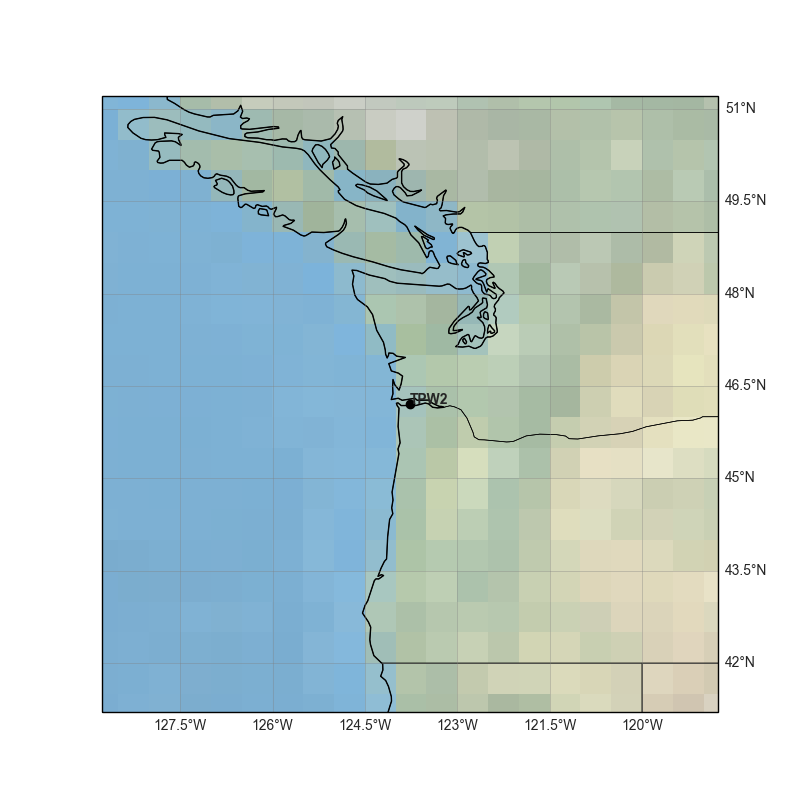

In [14]:
ax = plot_map(dfs)

In [15]:
print('{} stations in the vicinity'.format(len(subset)))
subset.head()

206 stations in the vicinity


,site,description,lat,lon,height,start,end
0,ALBH,Albert Head_COMMA_ BC,48.3890,-123.4870,0.0,NaN,NaN
1,ARLI,Arlington_COMMA_ WA,48.1740,-122.1418,0.0,NaN,NaN
2,ARLN,Arlington_COMMA_ OR,45.7082,-120.1832,0.0,NaN,NaN
3,ASHL,Ashland_COMMA_ OR,42.1806,-122.6701,0.0,NaN,NaN
4,AXIS,E. Wenatchee_COMMA_ WA,47.4043,-120.2847,0.0,NaN,NaN


<IPython.core.display.Javascript object>


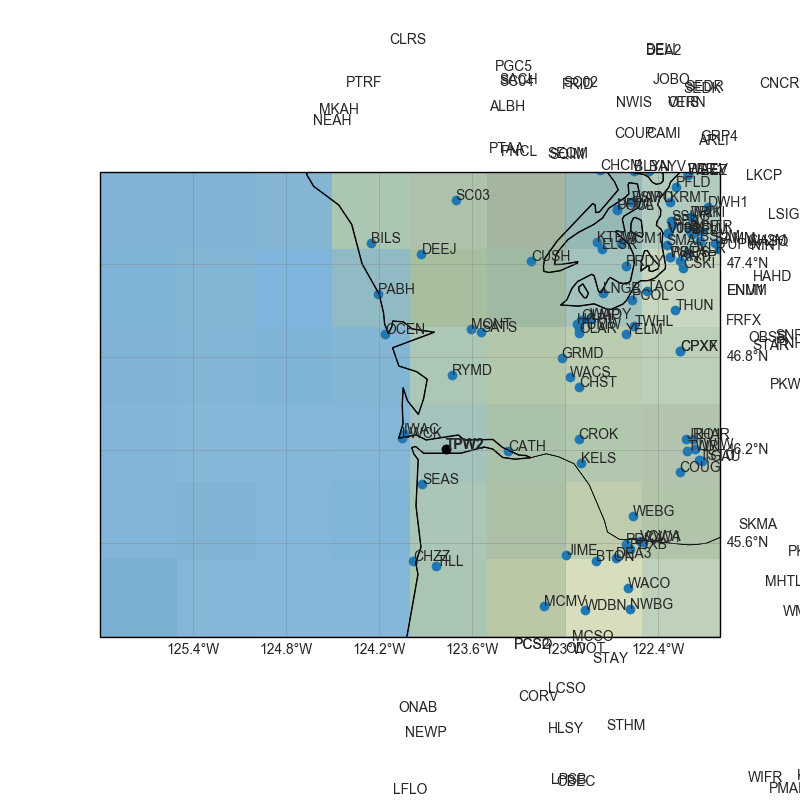

(45, 48)

In [16]:

# NOTE: cartopy is smart enough to figure out lon -127 or 227 converntions
ax = plot_map(dfs)
ax.scatter(subset.lon, subset.lat,  transform=ccrs.Geodetic())
for i in range(len(subset)):
    ax.text(subset.lon.iloc[i], subset.lat.iloc[i], subset.site.iloc[i], transform=ccrs.Geodetic())

plt.xlim(-126, -122)
plt.ylim(45,48)

In [17]:
# get distance to these other stations
import geopandas as gpd
from shapely.geometry import Point
geom = subset.apply(lambda row: Point(row.lon, row.lat), axis=1)
gf = gpd.GeoDataFrame(subset, crs="+init=epsg:4326", geometry=geom)
#gf['distance'] = gf.distance(Point(dfs.lon,dfs.lat))
 #NOTE this is in weird degree units. switch to UTM
#EPSG:32610 WGS84 10North

gf = gf.to_crs({'init': 'epsg:32610'})

site = gf.query('site == @station')

gf['distance'] = gf.distance( site.geometry.iloc[0])/1e3 #distance in kilometres
gf.sort_values('distance')

,site,description,lat,lon,height,start,end,geometry,distance
167,TPW2,Astoria_COMMA_ OR,46.2074,-123.7684,0.0,NaN,NaN,POINT (440723.7789708629 5117378.40361983),0.000000
85,LWCK,Ilwaco_COMMA_ WA,46.2781,-124.0538,0.0,NaN,NaN,POINT (418811.7921511952 5125486.677437812),23.364059
66,IWAC,Ilwaco_COMMA_ WA,46.3058,-124.0394,0.0,NaN,NaN,POINT (419961.5753663715 5128549.825769153),23.576891
146,SEAS,Seaside_COMMA_ OR,45.9842,-123.9224,0.0,NaN,NaN,POINT (428556.2081854839 5092705.594333944),27.509949
20,CATH,Cathlamet_COMMA_ WA,46.1972,-123.3672,0.0,NaN,NaN,POINT (471668.0410270081 5116023.668421188),30.973903
138,RYMD,Raymond_COMMA_ WA,46.6841,-123.7303,0.0,NaN,NaN,POINT (444152.2155849158 5170319.231272723),53.051724
35,CROK,Castle Rock_COMMA_ WA,46.2745,-122.9125,0.0,NaN,NaN,POINT (506741.7446881864 5124550.780415792),66.406436
70,KELS,Kelso_COMMA_ WA,46.1182,-122.8961,0.0,NaN,NaN,POINT (508028.0689029996 5107185.705630698),68.071716
204,CHST,Chehalis_COMMA_ WA,46.6121,-122.9095,0.0,NaN,NaN,POINT (506929.9507346067 5162063.634643632),79.875072
179,WACS,Chehalis_COMMA_ WA,46.6754,-122.9700,0.0,NaN,NaN,POINT (502294.5434364163 5169093.953869674),80.408067


<IPython.core.display.Javascript object>


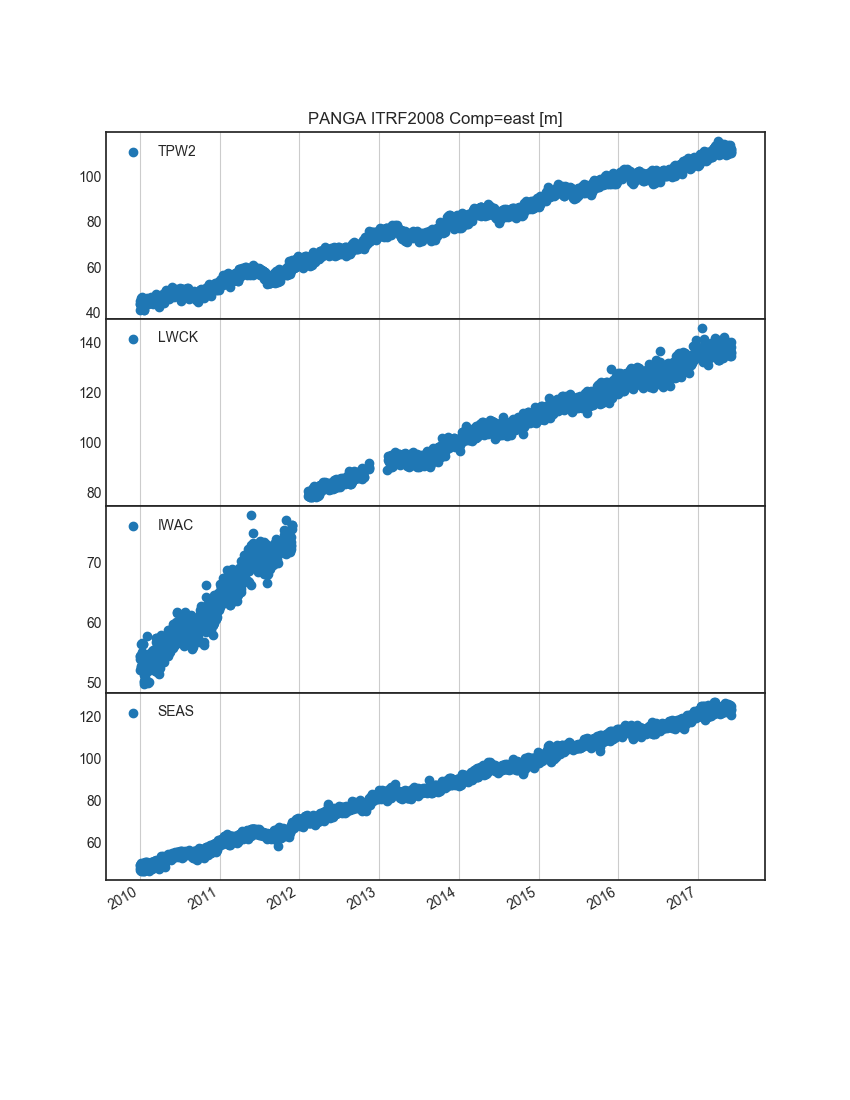

TPW2 already dowloaded... skipping
TPW2 already dowloaded... skipping
TPW2 already dowloaded... skipping
LWCK already dowloaded... skipping
LWCK already dowloaded... skipping
LWCK already dowloaded... skipping
IWAC already dowloaded... skipping
IWAC already dowloaded... skipping
IWAC already dowloaded... skipping
SEAS already dowloaded... skipping
SEAS already dowloaded... skipping
SEAS already dowloaded... skipping


In [18]:
# Make a comparison plot for particular component, list of stations
sites = ['TPW2','LWCK', 'IWAC','SEAS'] #less than 30km
comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, figsize=(8.5,11))
for i,site in enumerate(sites):
    ax = axes[i]
    gps.panga.download_data(site, overwrite=False)
    tmp = gps.panga.load_panga(site)
    tmp = tmp['2010/01/01':'2017/06/01']#specific time range
    ax.scatter(tmp.index, tmp[comp],label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')

axes[0].set_title('PANGA ITRF2008 Comp={} [m]'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

<IPython.core.display.Javascript object>


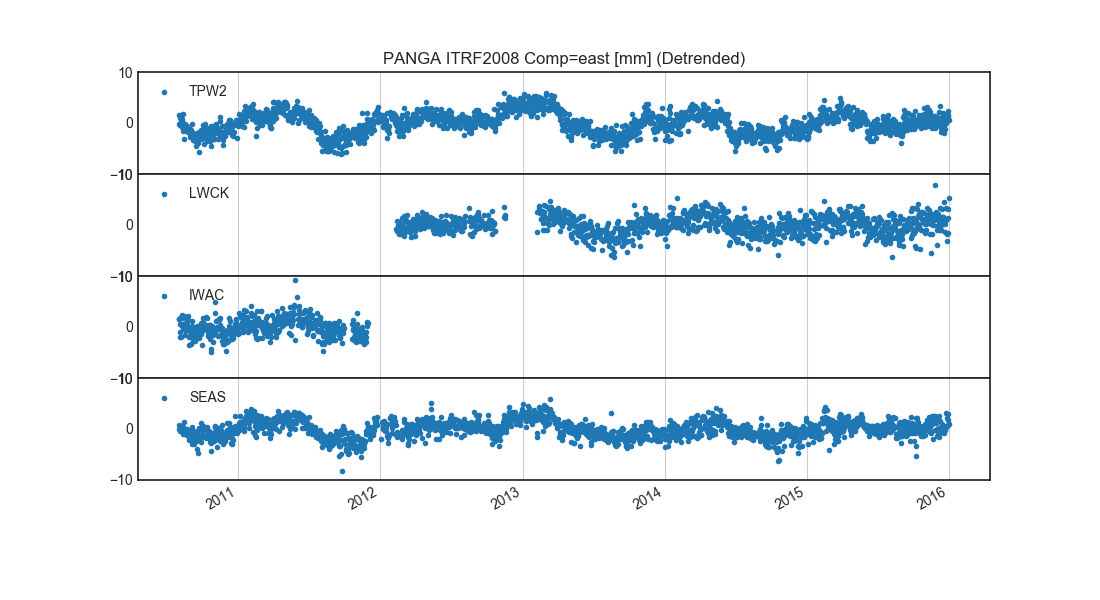

east Rate [mm/yr]=9221.39034103929
RMSE =  2.12704800302
east Rate [mm/yr]=11012.11182582813
RMSE =  1.76831330999
east Rate [mm/yr]=12957.604278902038
RMSE =  1.78714440925
east Rate [mm/yr]=10493.378612842005
RMSE =  1.64700307175


(-10, 10)

In [19]:
# Same plot, detrend the data
sites = ['TPW2','LWCK', 'IWAC','SEAS'] #less than 30km
comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(11,6))
for i,site in enumerate(sites):
    ax = axes[i]
    tmp = gps.panga.load_panga(site)
    #tmp = tmp['2010/01/01':'2017/06/01']#specific time range
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')

axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.ylim(-10,10)

# Fit velocity to timeseries

In [20]:
# Basic statistics for each component
df[ ['east', 'north', 'up'] ].describe()

,east,north,up
count,6231.000000,6231.000000,6231.000000
mean,34.608674,30.022578,-1.578092
std,44.584029,38.970899,6.676763
min,-45.939430,-43.902240,-31.515870
25%,-6.710965,-4.619230,-6.031490
50%,37.781440,30.828990,-1.631700
75%,74.117330,64.901055,3.013340
max,115.929030,100.028170,20.384040


In [21]:
dfF = gps.analysis.fit_linear(df)

In [22]:
# Table of values
for comp in ['east','north','up']:
    x = df.decyear
    y = df[comp]
    z,cov = np.polyfit(x, y, 1, cov=True)
    p = np.poly1d(z)
    #print(p)
    stderr = 2*np.sqrt(np.diag(cov))
    print('{}: {:.2f} +/- {:.2f} mm/yr'.format(comp, z[0], stderr[0]))
    residuals = (p(x) - y)
    rmse = np.sqrt((np.sum(residuals**2) / residuals.size))
    print('rmse = {:.2f}'.format(rmse))

east: 8.95 +/- 0.02 mm/yr
rmse = 2.94
north: 7.83 +/- 0.01 mm/yr
rmse = 2.40
up: 0.14 +/- 0.03 mm/yr
rmse = 6.64


<IPython.core.display.Javascript object>


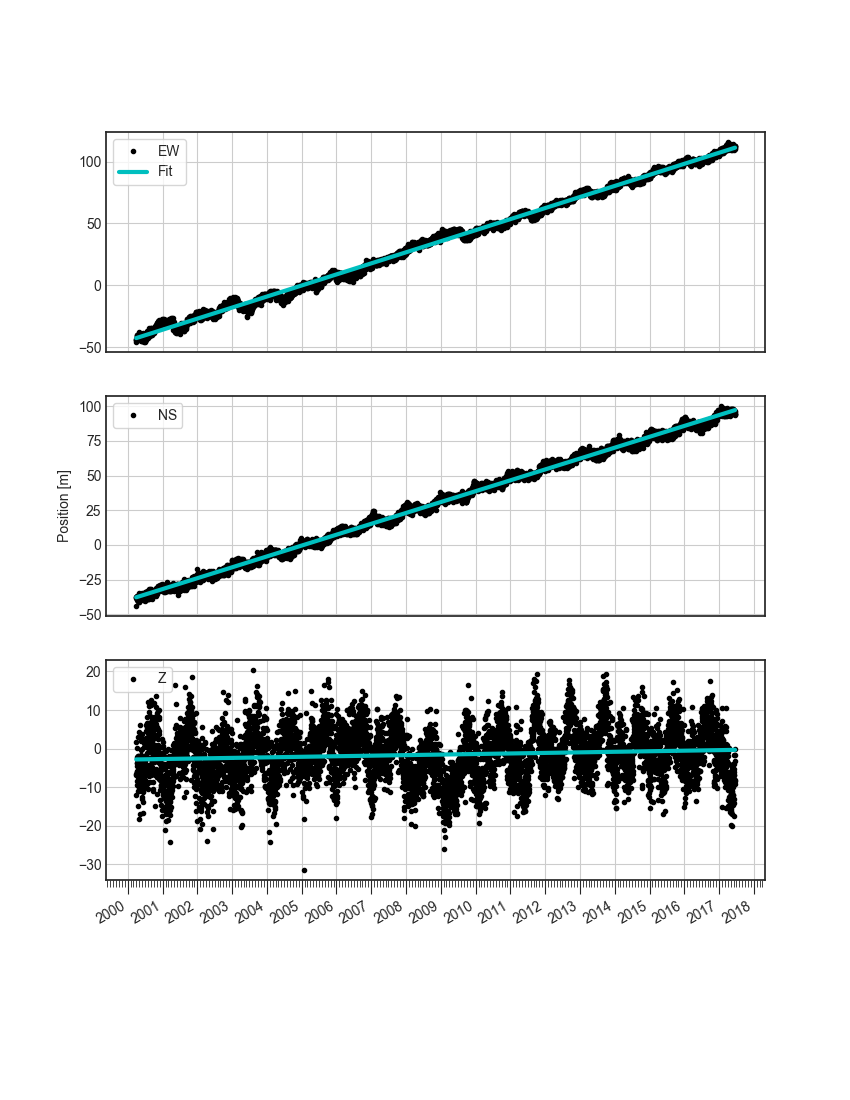

In [23]:
gps.plot.all(df,dfFit=dfF)